# 🧪 Custom kNN Classification With HNSW

In this notebook, we implement kNN with HNSW **from scratch**. We then compare the performance of these implementations with **scikit-learn**'s `KNeighborsClassifier` model.

### ⚙️ Importing Libraries & Environment Setup

In [13]:
import heapq
from collections import defaultdict
from math import ceil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.typing import NDArray
from sklearn.datasets import make_classification
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm

In [14]:
%matplotlib inline

pd.set_option("display.width", 150)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

### 🧰 Utility Functions

In [15]:
def evaluate_classification_models(
    predictions: dict[str, NDArray[np.float64]], y: NDArray[np.float64]
) -> pd.DataFrame:
    """Evaluate multiple classification model predictions on the provided dataset.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary mapping model names
            to predicted target arrays (binary or probabilities) for the dataset.
        y (NDArray[np.float64]): True binary target values of shape (n_samples,).

    Returns:
        pd.DataFrame: DataFrame containing classification metrics — Accuracy, Precision,
            Recall and F1-score — for each model. Columns correspond to
            model names, rows correspond to the metric names.
    """
    evaluations = pd.DataFrame(
        columns=predictions.keys(),
        index=["Accuracy", "Precision", "Recall", "F1-score"],
    )

    for name, y_pred in predictions.items():
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred, average="weighted")
        recall = recall_score(y, y_pred, average="weighted")
        f1 = f1_score(y, y_pred, average="weighted")

        evaluations.loc[:, name] = [accuracy, precision, recall, f1]

    return evaluations.astype(float)

In [16]:
def plot_confusion_matrices(
    predictions: dict[str, NDArray[np.int64]],
    y_true: NDArray[np.int64],
    n_cols: int = 2,
) -> None:
    """Plot confusion matrices for multiple classification models.

    Each confusion matrix compares the true labels to predictions from one model.
    The plots are arranged in a grid layout for easy comparison.

    Args:
        predictions (dict[str, NDArray[np.int64]]): A dictionary mapping model names to
            their predicted labels (1D array of shape (n_samples,)).
        y_true (NDArray[np.int64]): True class labels (1D array of shape (n_samples,)).
        n_cols (int, optional): Number of columns in the subplot grid layout.
            Default is 2.
    """
    n_models = len(predictions)
    n_cols = min(n_models, n_cols)
    n_rows = ceil(n_models / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, (name, y_pred) in zip(axes, predictions.items(), strict=False):
        conf_matrix = confusion_matrix(y_true, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
        ax.set_title(name)

    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

### 📥 Loading the Dataset

In [17]:
# Generate dataset
X, y = make_classification(
    n_samples=10000,
    n_features=2,
    n_informative=2,
    n_classes=4,
    n_clusters_per_class=1,
    n_redundant=0,
    class_sep=1.8,
    random_state=42,
)

In [18]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 🧠 Implementing Custom Model Algorithms

In [19]:
class Node:
    """A node in the HNSW graph.

    Attributes:
        data (NDArray[np.float64]): Feature vector of the data point.
        idx (int): Unique index of the data point in the dataset.
        level (int): Maximum level this node exists on in the graph.
        connections (dict[int, list[Node]]): Neighbors of the node for each level.
    """

    def __init__(self, point: NDArray[np.float64], idx: int, level: int) -> None:
        """Initialize a node for the HNSW graph.

        Args:
            point (NDArray[np.float64]): Feature vector of the data point.
            idx (int): Index of the data point in the dataset.
            level (int): Maximum level this node will exist on.
        """
        self.point = point
        self.idx = idx
        self.level = level

        self.connections: dict[int, list["Node"]] = defaultdict(list)


class HNSWIndex:
    """HNSW index for efficient approximate nearest neighbor search.

    Attributes:
        M (int): Maximum number of connections per node.
        ef_construction (int): Size of the candidate list during graph construction.
        ef_search (int): Size of the candidate list during querying.
        max_level (int): Current highest level in the graph.
        entry_point (Node | None): Starting node for traversal during search
            and insertion.
        p (float): Order of the Minkowski distance metric.
    """

    def __init__(
        self,
        max_connections: int,
        ef_construction: int,
        ef_search: int,
        p: float = 2.0,
        random_state: int | None = None,
    ) -> None:
        """Initialize an HNSW index.

        Args:
            max_connections (int): Maximum number of connections (M) per node.
            ef_construction (int): Size of the dynamic candidate list used during
                index construction.
            ef_search (int): Size of the candidate list used during querying.
            p (float, optional): Order of the Minkowski distance.
                Default is 2 (Euclidean distance).
            random_state (int | None, optional): Random seed for reproducibility.
        """
        self.M = max_connections
        self.ef_construction = ef_construction
        self.ef_search = ef_search
        self.p = p

        self.max_level: int = -1
        self.entry_point: Node | None = None

        if random_state is not None:
            np.random.seed(random_state)

    def _generate_random_level(self, max_level: int = 16) -> int:
        """Generate a random level for a new node using an exponential distribution.

        Args:
            max_level (int): Maximum allowed level for any node.

        Returns:
            int: Assigned level for the new node.
        """
        lambda_exp = 1 / np.log(self.M)
        exp_sample = np.random.exponential(scale=1 / lambda_exp)
        level = int(exp_sample)
        return min(level, max_level)

    def _minkowski_metric(
        self, a: NDArray[np.float64], b: NDArray[np.float64]
    ) -> float:
        """Calculate Minkowski distance of order p between two points.

        Args:
            a (NDArray[np.float64]): First point.
            b (NDArray[np.float64]): Second point.
            p (float): Order of the Minkowski distance.

        Returns:
            float: Minkowski distance between points a and b.
        """
        return np.sum(np.abs(a - b) ** self.p) ** (1 / self.p)

    def _search_layer(
        self, point: NDArray[np.float64], entry_point: Node, level: int, ef_search: int
    ) -> list[tuple[float, Node]]:
        """Search for nearest neighbors of a point within a specific graph level.

        Args:
            point (NDArray[np.float64]): Query point.
            entry_point (Node): Starting node for the search.
            level (int): Level of the graph to search in.
            ef_search (int): Size of the candidate pool to maintain during search.

        Returns:
            list[tuple[float, Node]]:: List of (distance, node) tuples, sorted
                by distance.
        """
        visited: set[int] = set()
        candidates: list[tuple[float, Node]] = []
        heap: list[tuple[float, Node]] = []

        dist = self._minkowski_metric(point, entry_point.point)
        heapq.heappush(heap, (dist, entry_point))
        heapq.heappush(candidates, (-dist, entry_point))
        visited.add(entry_point.idx)

        while candidates:
            curr_dist, curr_node = heapq.heappop(candidates)
            closest_dist, _ = heap[0]

            if -curr_dist > closest_dist:
                break

            for neighbor in curr_node.connections[level]:
                if neighbor.idx in visited:
                    continue

                visited.add(neighbor.idx)
                new_dist = self._minkowski_metric(point, neighbor.point)
                heapq.heappush(heap, (new_dist, neighbor))
                heapq.heappush(candidates, (-new_dist, neighbor))

                if len(heap) > ef_search:
                    heapq.heappop(heap)

        return sorted(heap, key=lambda x: x[0])

    def _greedy_search_level(
        self, point: NDArray[np.float64], entry_point: Node, level: int
    ) -> tuple[Node, float]:
        """Perform greedy search to find the closest node on a given level.

        Args:
            point (NDArray[np.float64]): Query point.
            entry_point (Node): Starting node for the search.
            level (int): Level in which to perform the search.

        Returns:
            tuple[Node, float]: Closest node and its distance to the query point.
        """
        current_node = entry_point
        current_dist = self._minkowski_metric(point, current_node.point)

        changed = True
        while changed:
            changed = False
            for neighbor in current_node.connections.get(level, []):
                new_dist = self._minkowski_metric(point, neighbor.point)
                if new_dist < current_dist:
                    current_dist = new_dist
                    current_node = neighbor
                    changed = True

        return current_node, current_dist

    def add(self, point: NDArray[np.float64], idx: int) -> None:
        """Insert a new point into the HNSW index.

        Args:
            point (NDArray[np.float64]): Data point to insert.
            idx (int): Unique index of the data point in the dataset.
        """
        if point.shape[0] == 0:
            return

        level = self._generate_random_level()
        new_node = Node(point, idx, level)

        if self.entry_point is None:
            self.entry_point = new_node
            self.max_level = level
            return

        curr_entry = self.entry_point
        for current_level in range(self.max_level, level, -1):
            curr_entry, _ = self._greedy_search_level(point, curr_entry, current_level)

        for current_level in range(level, self.max_level + 1):
            neighbors = self._search_layer(
                point, curr_entry, current_level, self.ef_construction
            )
            selected = neighbors[: self.M]
            new_node.connections[current_level] = [node for _, node in selected]

            for _, neighbor in selected:
                neighbor.connections[current_level].append(new_node)
                if len(neighbor.connections[current_level]) <= self.M:
                    continue

                neighbor.connections[current_level] = sorted(
                    neighbor.connections[current_level],
                    key=lambda n: self._minkowski_metric(neighbor.point, n.point),
                )[: self.M]

    def search_k_nearest_neighbors(
        self, point: NDArray[np.float64], k: int
    ) -> list[tuple[float, Node]]:
        """Search for the k approximate nearest neighbors of a query point.

        Args:
            point (NDArray[np.float64]): Query point.
            k (int): Number of nearest neighbors to retrieve.

        Returns:
            list[tuple[float, Node]]: List of (distance, node) tuples for the k
                nearest neighbors.
        """
        if point.shape[0] == 0:
            return []

        curr_entry = self.entry_point
        for current_level in range(self.max_level, 0, -1):
            curr_entry, _ = self._greedy_search_level(point, curr_entry, current_level)

        neighbors = self._search_layer(point, curr_entry, 0, self.ef_search)
        return neighbors[:k]

In [20]:
class MyKNeighborsClassifier:
    """K-Nearest Neighbors Classifier with Gaussian kernel weighting & HNSW.

    Predicts the class label for each input sample based on the weighted vote
    of its k nearest neighbors in the training data, using Minkowski distance
    and a Gaussian kernel to assign weights to neighbors.

    Attributes:
        k_neighbors (int): Number of nearest neighbors to consider.
        p (float): Power parameter for the Minkowski distance.
        h (float): Bandwidth parameter for the Gaussian kernel.
        M (int): Maximum number of connections per node.
        ef_construction (int): Size of the candidate list during graph construction.
        ef_search (int): Size of the candidate list during querying.
        X_train (NDArray[np.float64] | None): Training features.
        y_train (NDArray[np.float64] | None): Training labels.
        hnsw (HNSWIndex | None): HNSW index structure.
    """

    def __init__(
        self,
        k_neighbors: int,
        max_connections: int,
        ef_construction: int,
        ef_search: int,
        h: float = 1.0,
        p: int = 2,
        random_state: int | None = None,
    ) -> None:
        """Initialize the KNN classifier.

        Args:
            k_neighbors (int): Number of neighbors to consider.
            max_connections (int): Maximum number of connections (M) per node.
            ef_construction (int): Size of the dynamic candidate list used during
                index construction.
            ef_search (int): Size of the candidate list used during querying.
            h (float, optional): Bandwidth parameter for the Gaussian kernel.
                Defaults to 1.0.
            p (float, optional): Order of the Minkowski distance. Default is 2
                (Euclidean distance).
            random_state (int | None, optional): Random seed for reproducibility.
                Default None.
        """
        self.k_neighbors = k_neighbors
        self.h = h
        self.p = p

        self.X_train: NDArray[np.float64] | None = None
        self.y_train: NDArray[np.int64] | None = None
        self.hnsw: HNSWIndex = HNSWIndex(
            max_connections=max_connections,
            ef_construction=ef_construction,
            ef_search=ef_search,
            p=p,
            random_state=random_state,
        )

    def _gaussian_kernel(self, t: NDArray[np.float64]) -> NDArray[np.float64]:
        """Gaussian (normal) kernel function.

        Args:
            t (NDArray[np.float64]): Input values.

        Returns:
            NDArray[np.float64]: Kernel-weighted values.
        """
        return np.exp(-(t**2) / 2) / np.sqrt(2 * np.pi)

    def fit(self, X: NDArray[np.float64], y: NDArray[np.int64]) -> None:
        """Store training data for future predictions.

        Args:
            X (NDArray[np.float64]): Training feature matrix of shape
                (n_samples, n_features).
            y (NDArray[np.int64]): Target values of shape (n_samples,).
        """
        self.X_train = X
        self.y_train = y
        for idx, point in enumerate(tqdm(X, desc="Indexing")):
            self.hnsw.add(point, idx)

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.int64]:
        """Predict class labels for input samples.

        Args:
            X (NDArray[np.float64]): Input samples of shape (n_samples, n_features).

        Returns:
            NDArray[np.int64]: Predicted class labels.
        """
        y_pred = []
        for x_new in tqdm(X, desc="Predicting"):
            neighbors = self.hnsw.search_k_nearest_neighbors(x_new, self.k_neighbors)

            neighbor_distances, neighbor_idx = zip(
                *[(dist, node.idx) for dist, node in neighbors], strict=False
            )
            neighbor_distances = np.array(neighbor_distances)
            neighbor_labels = y_train[np.array(neighbor_idx)]

            weights = self._gaussian_kernel(neighbor_distances / self.h)

            class_weights = {}
            for label, weight in zip(neighbor_labels, weights, strict=False):
                class_weights[label] = class_weights.get(label, 0) + weight

            predicted_label = max(class_weights, key=class_weights.get)
            y_pred.append(predicted_label)

        return np.array(y_pred, dtype=np.int64)

### 🏋️‍♂️ Model Training

In [21]:
# Scikit-learn kNN classifier model
sklearn_model = KNeighborsClassifier(n_neighbors=5, algorithm="kd_tree")
sklearn_model.fit(X_train, y_train)

# My kNN classifier with hnsw model
my_model = MyKNeighborsClassifier(
    k_neighbors=5,
    max_connections=24,
    ef_construction=300,
    ef_search=300,
    p=5,
    random_state=42,
    h=5.8,
)
my_model.fit(X_train, y_train)

Indexing:   0%|          | 0/8000 [00:00<?, ?it/s]

### 📊 Comparing Algorithm Versions

In [22]:
predictions = {
    "scikit-learn": sklearn_model.predict(X_test),
    "my hnsw": my_model.predict(X_test),
}

Predicting:   0%|          | 0/2000 [00:00<?, ?it/s]

In [23]:
evaluate_classification_models(predictions, y_test)

,scikit-learn,my hnsw
Accuracy,0.985000,0.949500
Precision,0.985054,0.950534
Recall,0.985000,0.949500
F1-score,0.984996,0.949552


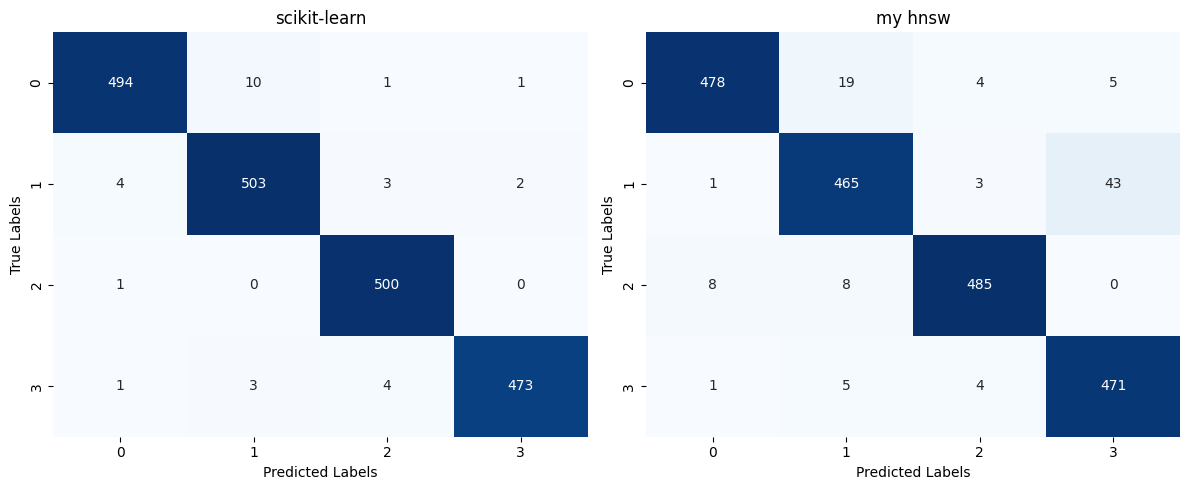

In [24]:
plot_confusion_matrices(predictions, y_test)